# AP1: Hands-on tutorial 2: Advanced topics
This tutorial covers advanced ML topics. In Part 1 and 2, we will look at diagnostic tools for get insights into how the models work. In Part 3 we will look at more in-depth evaluation of model results. In Part 4 we will investigate advanced ML-models.

## Preparation
Set up dataset and model, like we did in hands-on tutorial 1.

In [1]:
import os, sys
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

import climetlab as cml
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

%matplotlib inline

/p/project/training2330/kreshpa1/jupyter/kernels/venv_bootcamp3/lib/python3.10/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [2]:
# Set up datasets
loader = cml.load_dataset("maelstrom-yr", size="5GB", dates=pd.date_range(start="2020-03-01", end="2022-02-28", freq="1D"), normalize=True, predict_diff=True, location="/p/project/training2330/AP1/")
full_dataset = loader.to_xarray()
print(full_dataset)

""" Split the dataset into training, validation, and testing, based on dates """
datasets = dict()
datasets["train"] = full_dataset.sel(time=slice("2020-03-01", "2021-01-31"))
datasets["val"] = full_dataset.sel(time=slice("2021-02-01", "2022-02-28", 2))
datasets["test"] = full_dataset.sel(time=slice("2021-03-01", "2022-02-28", 2))

# Set up loss function
quantiles = [0.1,0.5,0.9]
""" The quantile score readable for keras/tensorflow"""
def quantile_score(y_true, y_pred, quantile_levels):
    qtloss = 0
    for i, quantile_level in enumerate(quantile_levels):
        err = y_true[..., 0] - y_pred[..., i]
        qtloss += (quantile_level - tf.cast((err < 0), tf.float32)) * err
    return K.mean(qtloss) / len(quantile_levels)


# loss = lambda x, y: quantile_score(x, y, quantiles)
def loss(x,y):
    return quantile_score(x,y,quantiles)

input_shape = datasets["train"]["predictors"].shape[1:]
num_outputs = len(quantiles)
print(datasets["train"])
print(input_shape)

Cannot load module climetlab_maelstrom_downscaling.downscaling
Traceback (most recent call last):
  File "/p/project/training2330/kreshpa1/jupyter/kernels/venv_bootcamp3/lib/python3.10/site-packages/climetlab/core/plugins.py", line 187, in directories
    module = import_module(v.module_name)
  File "/p/software/jurecadc/stages/2023/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/p/project/training2330/kreshpa1/jupyter/kernels/venv_b

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/metno/maelstrom_yr/LICENSE. If you do not agree with such terms, do not download the data. 
<xarray.Dataset>
Dimensions:     (time: 724, x: 128, y: 128, leadtime: 10, predictor: 14,
                 target: 1)
Coordinates:
  * time        (time) datetime64[ns] 2020-03-01T03:00:00 ... 2022-02-28T21:0...
  * x           (x) float32 -3.104e+05 -3.094e+05 ... -1.844e+05 -1.834e+05
  * y           (y) float32 -4.173e+05 -4.163e+05 ... -2.913e+05 -2.903e+05
  * leadtime    (leadtime) timedelta64[ns] 0 days 00:00:00 ... 2 days 06:00:00
    latitude    (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    longitude   (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
  * predictor   (predictor) object 'air_temperature_0.1_2m' ... 'model_laf'
  * target      (target) object 'mean'
Data variables:
    predictors  (time, leadtime, y, x, predictor) float32 -0.5787

In [3]:
datasets["train"]

<xarray.Dataset>
Dimensions:     (time: 333, x: 128, y: 128, leadtime: 10, predictor: 14,
                 target: 1)
Coordinates:
  * time        (time) datetime64[ns] 2020-03-01T03:00:00 ... 2021-01-31T15:0...
  * x           (x) float32 -3.104e+05 -3.094e+05 ... -1.844e+05 -1.834e+05
  * y           (y) float32 -4.173e+05 -4.163e+05 ... -2.913e+05 -2.903e+05
  * leadtime    (leadtime) timedelta64[ns] 0 days 00:00:00 ... 2 days 06:00:00
    latitude    (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    longitude   (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
  * predictor   (predictor) object 'air_temperature_0.1_2m' ... 'model_laf'
  * target      (target) object 'mean'
Data variables:
    predictors  (time, leadtime, y, x, predictor) float32 -0.5787 ... -0.5334
    targets     (time, leadtime, y, x, target) float32 0.02561 -0.5872 ... 1.782

In [4]:
wind = np.sqrt(
    datasets["train"]["predictors"].sel(predictor="x_wind_10m").values**2 +
    datasets["train"]["predictors"].sel(predictor="y_wind_10m").values**2)
wind = np.expand_dims(wind,axis=-1)
train_with_wind = np.concatenate((datasets["train"]["predictors"].values, wind), axis=-1)
print(train_with_wind.shape)

(333, 10, 128, 128, 15)


In [5]:
datasets["train"].coords["predictor_plus_wind"] = list(datasets["train"].coords["predictor"].values) + ["wind_speed"]
datasets["train"]["predictors_plus_wind"] = (['time', 'leadtime', 'y', 'x', 'predictor_with_wind'], train_with_wind)

In [6]:
datasets["train"]

<xarray.Dataset>
Dimensions:               (time: 333, x: 128, y: 128, leadtime: 10,
                           predictor: 14, target: 1, predictor_plus_wind: 15,
                           predictor_with_wind: 15)
Coordinates:
  * time                  (time) datetime64[ns] 2020-03-01T03:00:00 ... 2021-...
  * x                     (x) float32 -3.104e+05 -3.094e+05 ... -1.834e+05
  * y                     (y) float32 -4.173e+05 -4.163e+05 ... -2.903e+05
  * leadtime              (leadtime) timedelta64[ns] 0 days 00:00:00 ... 2 da...
    latitude              (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    longitude             (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
  * predictor             (predictor) object 'air_temperature_0.1_2m' ... 'mo...
  * target                (target) object 'mean'
  * predictor_plus_wind   (predictor_plus_wind) <U22 'air_temperature_0.1_2m'...
Dimensions without coordinates: predictor_with_wind
Data variables:
    predictors            (time, leadtime, y, x, predictor) float32 -0.5787 ....
    targets               (time, leadtime, y, x, target) float32 0.02561 ... ...
    predictors_plus_wind  (time, leadtime, y, x, predictor_with_wind) float32 ...

In [7]:
# also add wind for test and val
wind_test = np.sqrt(
    datasets["test"]["predictors"].sel(predictor="x_wind_10m").values**2 +
    datasets["test"]["predictors"].sel(predictor="y_wind_10m").values**2)
wind_test = np.expand_dims(wind_test,axis=-1)
test_with_wind = np.concatenate((datasets["test"]["predictors"].values, wind_test), axis=-1)

In [8]:
datasets["test"].coords["predictor_plus_wind"] = list(datasets["test"].coords["predictor"].values) + ["wind_speed"]
datasets["test"]["predictors_plus_wind"] = (['time', 'leadtime', 'y', 'x', 'predictor_plus_wind'], test_with_wind)

Set up a basic neural network:

In [9]:
def create_basic_model(input_shape, num_outputs):
    return keras.Sequential([
        keras.layers.Input(input_shape),
        keras.layers.Dense(10, activation="relu"),
        keras.layers.Dense(10, activation="relu"),
        # keras.layers.Dense(1, activation="relu"), # this removes features from previous layers to forward layers
        keras.layers.Dense(10, activation="relu"),
        keras.layers.Dense(10, activation="relu"),
        keras.layers.Dense(num_outputs)
    ])

#input_shape = datasets["train"]["predictors_plus_wind"].shape[1:]
model = create_basic_model(input_shape, num_outputs)
optimizer = keras.optimizers.Adam(learning_rate=1.0e-2)
model.compile(optimizer, loss=loss)

## Part 1: Importance of each predictor

Here we will investigate the importance of each predictor. Each input predictor was chosen based on our belief that it can help discriminate between different types of forecast errors. Ideally, the neural network can exploit each predictor by identify these signals in the data. To test this, we can measure how important each predictor is in a trained model. This is done by randomly shuffling each input predictor and recording the resulting increase in the loss value. Important predictors will have a large increase in loss, predctors that are ignored by the model will have no change in loss.

Start by training the model:

In [10]:
model.fit(datasets["train"]["predictors"].values, datasets["train"]["targets"].values, epochs=10, batch_size=1)

Epoch 1/10
333/333 [==============================] - 4s 4ms/step - loss: 0.3390
Epoch 2/10
333/333 [==============================] - 1s 4ms/step - loss: 0.3254
Epoch 3/10
333/333 [==============================] - 1s 4ms/step - loss: 0.3239
Epoch 4/10
333/333 [==============================] - 1s 4ms/step - loss: 0.3210
Epoch 5/10
333/333 [==============================] - 1s 4ms/step - loss: 0.3219
Epoch 6/10
333/333 [==============================] - 1s 4ms/step - loss: 0.3202
Epoch 7/10
333/333 [==============================] - 1s 4ms/step - loss: 0.3187
Epoch 8/10
333/333 [==============================] - 1s 4ms/step - loss: 0.3179
Epoch 9/10
333/333 [==============================] - 1s 4ms/step - loss: 0.3176
Epoch 10/10
333/333 [==============================] - 1s 4ms/step - loss: 0.3194


Next we will define a function that, for a given predictor, shuffles the values across all the different cases (different times and/or different grid points):

In [11]:
def predictor_importance(model, dataset, predictor=None, predictors=None):
    """ Performs a permutation study on a dataset

    Args:
        model (keras.model.Model): Compiled model to perform study on
        dataset (xarray.Dataset): xarray dataset with keys "predictors", "targets", "predictor"
    """
    if predictor is None:
        predictor = "predictor"
    if predictors is None:
        predictors = "predictors"
    loss = model.evaluate(dataset[predictors].values, dataset["targets"].values, verbose=False)
    print("Original loss:", loss)

    # Iterate over each predictor, permute its order, and compute loss
    print("Variable                       loss   skill_score")
    for i in range(len(dataset[predictor])):
        # Permute the predictor
        predictors = np.copy(dataset[predictors])
        curr_predictor = predictors[..., i].flatten()
        np.random.shuffle(curr_predictor)
        predictors[..., i] = np.reshape(curr_predictor, predictors.shape[0:-1])

        curr_loss = model.evaluate(predictors, dataset["targets"].values, verbose=False)

        name = str(dataset[predictor].values[i])
        skill_score = (loss - curr_loss) / loss * 100
        print(f"{name:25s} {curr_loss:-9.2f} {skill_score:-11.2f} %")

Let's run the study on the trained model:

In [12]:
datasets["test"]

<xarray.Dataset>
Dimensions:               (time: 182, x: 128, y: 128, leadtime: 10,
                           predictor: 14, target: 1, predictor_plus_wind: 15)
Coordinates:
  * time                  (time) datetime64[ns] 2021-03-01T03:00:00 ... 2022-...
  * x                     (x) float32 -3.104e+05 -3.094e+05 ... -1.834e+05
  * y                     (y) float32 -4.173e+05 -4.163e+05 ... -2.903e+05
  * leadtime              (leadtime) timedelta64[ns] 0 days 00:00:00 ... 2 da...
    latitude              (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    longitude             (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
  * predictor             (predictor) object 'air_temperature_0.1_2m' ... 'mo...
  * target                (target) object 'mean'
  * predictor_plus_wind   (predictor_plus_wind) <U22 'air_temperature_0.1_2m'...
Data variables:
    predictors            (time, leadtime, y, x, predictor) float32 -0.4496 ....
    targets               (time, leadtime, y, x, target) float32 -2.011 ... -...
    predictors_plus_wind  (time, leadtime, y, x, predictor_plus_wind) float32 ...

In [13]:
predictor_importance(model, datasets["test"]) #, "predictor_plus_wind", "predictors_plus_wind") # skill_score es respecto a una referencia (loss en la funcion anterior) por eso al quitar variables importantes cae tanto el skill_score

ValueError: in user code:

    File "/p/software/jurecadc/stages/2023/software/TensorFlow/2.11.0-gcccoremkl-11.3.0-2022.1.0-CUDA-11.7/lib/python3.10/site-packages/keras/engine/training.py", line 1820, in test_function  *
        return step_function(self, iterator)
    File "/p/software/jurecadc/stages/2023/software/TensorFlow/2.11.0-gcccoremkl-11.3.0-2022.1.0-CUDA-11.7/lib/python3.10/site-packages/keras/engine/training.py", line 1804, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/p/software/jurecadc/stages/2023/software/TensorFlow/2.11.0-gcccoremkl-11.3.0-2022.1.0-CUDA-11.7/lib/python3.10/site-packages/keras/engine/training.py", line 1792, in run_step  **
        outputs = model.test_step(data)
    File "/p/software/jurecadc/stages/2023/software/TensorFlow/2.11.0-gcccoremkl-11.3.0-2022.1.0-CUDA-11.7/lib/python3.10/site-packages/keras/engine/training.py", line 1756, in test_step
        y_pred = self(x, training=False)
    File "/p/software/jurecadc/stages/2023/software/TensorFlow/2.11.0-gcccoremkl-11.3.0-2022.1.0-CUDA-11.7/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/p/software/jurecadc/stages/2023/software/TensorFlow/2.11.0-gcccoremkl-11.3.0-2022.1.0-CUDA-11.7/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 10, 128, 128, 14), found shape=(None, 10, 128, 128, 15)


As expected, the temperature variables are very important, as well as the two altitude variables. These results also suggest that the model cannot, for example, make use of the cloud_area_fraction predictor.

- _**Exercise**: Change the architecture of the model above and see how it affects the predictor importance results._

Sometimes it can be useful to train a model on a subset of predictors, to further test the value of the predictors. There are two ways to do this. 1) You can change the loader using the "limit_predictors" argument such that only a subset of parameters are loaded (see Handson-1); or 2) you can subset the predictors after loading the xarray object. 2) Is easier when exploring because then you can keep the original data and don't have to reload the data from disk every time you change the predictors.

Let's write a function that creates a new dataset based on subsetting an existing dataset:

In [14]:
def subset_dataset(dataset, predictors=None, leadtimes=None):
    """Create a dataset containing a subset of predictors and/or leadtimes
    
    NOTE: This function does not make a copy of the underlying data, it prividesa
    view into the existing dataset

    Args:
        dataset (xarray.Dataset): Dataset with predictors and targets
        predictors (list): Only keep these predictor names. Keep all if None.
        leadtimes (list): Only keep these leadtimes. Keep all if None.

    Returns:
        xarray.Dataset
    """
    new_dataset = dataset
    if predictors is not None:
        new_dataset = new_dataset.sel(predictor=predictors)
    if leadtimes is not None:
        new_dataset = new_dataset.sel(leadtime=leadtimes)
    return new_dataset

Let's train a model using only air_temperature_2m and cloud_area_fraction. Note that you will have to reinitialize the model, since the input shape will change:

In [15]:

pred = ["air_temperature_2m", "cloud_area_fraction"]

new_train_dataset = subset_dataset(datasets["train"], predictors=pred)

input_shape_small = new_train_dataset["predictors"].shape[1:]
model_small = create_basic_model(input_shape_small, num_outputs)
optimizer = keras.optimizers.Adam(learning_rate=1.0e-2)
model_small.compile(optimizer, loss=loss)
model_small.fit(new_train_dataset["predictors"].values, new_train_dataset["targets"].values, epochs=10, batch_size=1)

Epoch 1/10
333/333 [==============================] - 2s 2ms/step - loss: 0.3621
Epoch 2/10
333/333 [==============================] - 1s 2ms/step - loss: 0.3497
Epoch 3/10
333/333 [==============================] - 1s 2ms/step - loss: 0.3485
Epoch 4/10
333/333 [==============================] - 1s 2ms/step - loss: 0.3489
Epoch 5/10
333/333 [==============================] - 1s 2ms/step - loss: 0.3480
Epoch 6/10
333/333 [==============================] - 1s 2ms/step - loss: 0.3467
Epoch 7/10
333/333 [==============================] - 1s 2ms/step - loss: 0.3483
Epoch 8/10
333/333 [==============================] - 1s 2ms/step - loss: 0.3470
Epoch 9/10
333/333 [==============================] - 1s 2ms/step - loss: 0.3474
Epoch 10/10
333/333 [==============================] - 1s 2ms/step - loss: 0.3475


- _**Exercise**: Remove "air_temperature_0.1_2m" from the datasets, retrain the model, and rerun predictor_importance. Why does the loss not reduce greatly, even though an "important" predictor was removed? What can we say about the limitations of what predictor_importance tells us?_
- _**Exercise**: Train a model using only the predictors that have a large reduction in loss. How does the training time and accuracy relate to the model trained on all parameters?_
- _**Exercise**: Try to change the architecture of the model and see if the new model can make better use of more of the predictors._

## Part 2: Visualizing the neural network

In many cases, a neural network is a black box, and it can be challenging to understand what it is doing. In an attempt to help our understanding, we will try to visualize what happens inside the neural network. One way is to plot what the data looks like as it passes through the layers of the model, which might provide some insights into what signals it has picked up on.

To do this, we will pick a sample (a particular day) from our dataset, and propagate this starting state through each layer of a trained model, recording it at each step and plotting them at the end.

In [16]:
# Loop over each layer and plot the data after it has passed through the layer
def plot_model(model, dataset, time_index=0, leadtime_index=0):
    """Plots predictors as they pass through a neural network

    Color limits for outputs and targets are synchronized
    """    
    # Extract data for plotting
    start = dataset["predictors"].values[[time_index], ...]
    data_to_plot = dict()
    data_to_plot["input"] = start
    for l, layer in enumerate(model.layers):
        # print(start.shape, layer)
        try:
            start = layer(start)
            if l == len(model.layers) - 1:
                name = "output"
            else:
                name = f"layer{l}"
            data_to_plot[name] = start
        except Exception as e:
            pass
    data_to_plot["target"] = dataset["targets"].values[[time_index], ...]

    num_rows = len(data_to_plot)
    num_cols = min(15, np.max([v.shape[3] for k,v in data_to_plot.items()]))
    row = 0
    # FInd color limits for targets and outputs
    z_min = np.min([np.percentile(data_to_plot["output"], 5), np.percentile(data_to_plot["target"], 5)])
    z_max = np.max([np.percentile(data_to_plot["output"], 95), np.percentile(data_to_plot["target"], 95)])
    # Loop over each layer
    for name, values in data_to_plot.items():
        # Loop over the predictors
        for j in range(min(num_cols, values.shape[4])):
            plt.subplot(num_rows, num_cols, 1 + j + row * num_cols)
            curr = values[0, leadtime_index, :, :, j]
            if name in ["target", "output"]:
                plt.pcolormesh(curr, vmin=z_min, vmax=z_max, cmap="RdBu_r")
            else:
                plt.pcolormesh(curr, cmap="RdBu_r")
            plt.axis("off")
            plt.gca().set_aspect(1)
            if name == "input":
                plt.gca().set_title(dataset["predictor"].values[j], rotation=90, fontsize=8)
            elif j == 0:
                plt.gca().set_title(name)
        row += 1
    plt.gcf().set_size_inches(15, 15 / num_cols * num_rows)
    plt.show()

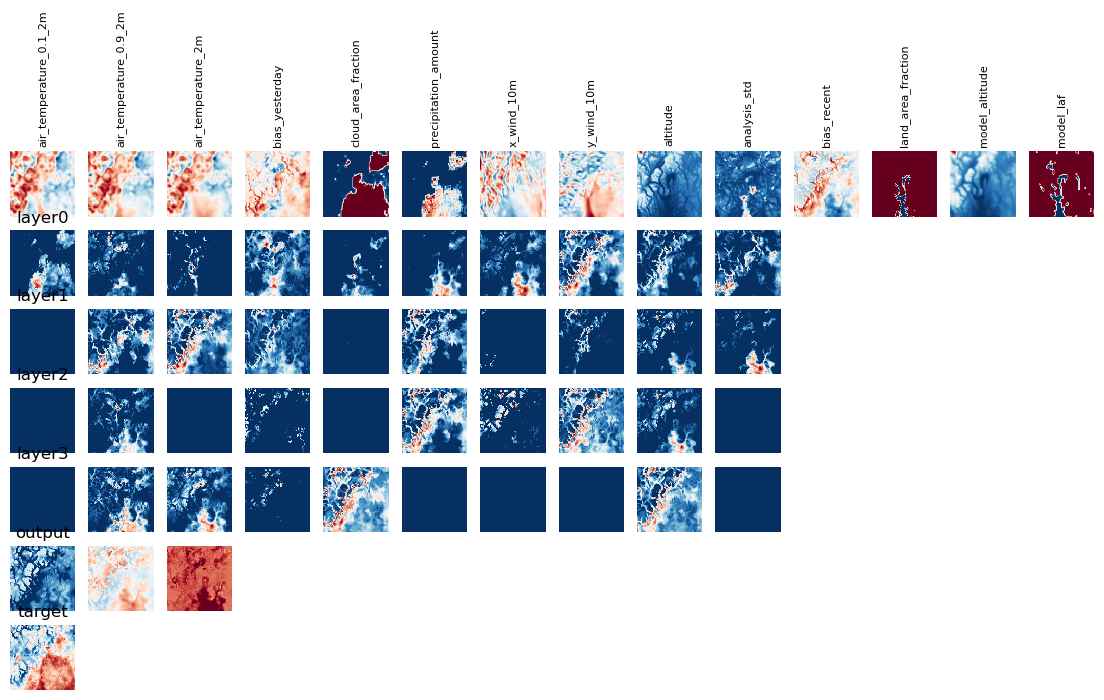

In [17]:
plot_model(model, datasets["test"], time_index=0, leadtime_index=8)


- _**Exercise**: Check what happens when more layers and/or more units in each layer are added_
- _**Exercise**: Check what happens if a 1-node layer is added somewhere in the model_

## Part 3: Evaluation
In this part, we will go deeper into evaluating the predictions. In addition to the loss function, there are a number of other relevant metrics we can look at.  For probabilistic forecasts, reliability is a metric that is useful to look at. This is the frequency of targets falling within the 10% to 90% interval. Ideally, this should be 80%.

In [18]:
def reliability(y_true, y_pred):
    return K.mean(tf.cast(y_pred[..., 0] < y_true[..., 0], tf.float32) * tf.cast(y_pred[..., -1] > y_true[..., 0], tf.float32))

Another one is sharpness, which is the width of the 10% to 90% interval. Ideally, this interval is narrow. Note that sharpness is not dependent on what the target values are. Sharpness alone isn't enough to quantify the quality of the forecast, since it is trivial to create forecasts that are perfectly sharp. It is therefore a useful companion metric to reliavility. Sharpness can be defined as follows:

In [19]:
def sharpness(y_true, y_pred):
    return K.mean(y_pred[..., -1] - y_pred[..., 0])

Tensorflow can compute these metrics during the training process. You simply pass the function handles as metrics when compiling the model:

In [20]:
datasets["train"]

<xarray.Dataset>
Dimensions:               (time: 333, x: 128, y: 128, leadtime: 10,
                           predictor: 14, target: 1, predictor_plus_wind: 15,
                           predictor_with_wind: 15)
Coordinates:
  * time                  (time) datetime64[ns] 2020-03-01T03:00:00 ... 2021-...
  * x                     (x) float32 -3.104e+05 -3.094e+05 ... -1.834e+05
  * y                     (y) float32 -4.173e+05 -4.163e+05 ... -2.903e+05
  * leadtime              (leadtime) timedelta64[ns] 0 days 00:00:00 ... 2 da...
    latitude              (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    longitude             (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
  * predictor             (predictor) object 'air_temperature_0.1_2m' ... 'mo...
  * target                (target) object 'mean'
  * predictor_plus_wind   (predictor_plus_wind) <U22 'air_temperature_0.1_2m'...
Dimensions without coordinates: predictor_with_wind
Data variables:
    predictors            (time, leadtime, y, x, predictor) float32 -0.5787 ....
    targets               (time, leadtime, y, x, target) float32 0.02561 ... ...
    predictors_plus_wind  (time, leadtime, y, x, predictor_with_wind) float32 ...

In [21]:
metrics = [sharpness, reliability]
optimizer = keras.optimizers.Adam(learning_rate=1.0e-2)
model.compile(optimizer, loss=loss, metrics=metrics) # metrics are not used for loss, son solo para q sepas como va la cosa
history = model.fit(
    datasets["train"]["predictors"].values,
    datasets["train"]["targets"].values,
    epochs=20,
    batch_size=32,
    validation_data=(datasets["val"]["predictors"].values, datasets["val"]["targets"].values))

Epoch 1/20
11/11 [==============================] - 7s 308ms/step - loss: 0.3140 - sharpness: 3.0570 - reliability: 0.8018 - val_loss: 0.3620 - val_sharpness: 3.1041 - val_reliability: 0.7629
Epoch 2/20
11/11 [==============================] - 1s 109ms/step - loss: 0.3100 - sharpness: 3.0699 - reliability: 0.8090 - val_loss: 0.3560 - val_sharpness: 3.2538 - val_reliability: 0.7879
Epoch 3/20
11/11 [==============================] - 1s 109ms/step - loss: 0.3098 - sharpness: 3.0083 - reliability: 0.8006 - val_loss: 0.3566 - val_sharpness: 3.1616 - val_reliability: 0.7722
Epoch 4/20
11/11 [==============================] - 1s 110ms/step - loss: 0.3086 - sharpness: 3.0091 - reliability: 0.8072 - val_loss: 0.3555 - val_sharpness: 3.2166 - val_reliability: 0.7823
Epoch 5/20
11/11 [==============================] - 1s 108ms/step - loss: 0.3078 - sharpness: 2.9278 - reliability: 0.7953 - val_loss: 0.3546 - val_sharpness: 3.3348 - val_reliability: 0.7935
Epoch 6/20
11/11 [======================

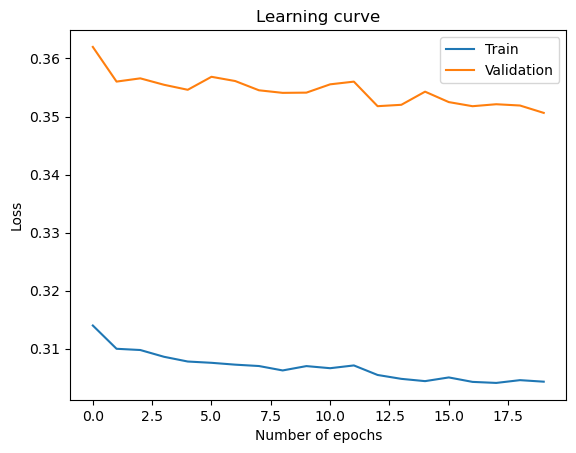

In [22]:
plt.plot(history.epoch, history.history["loss"], label="Train")
plt.plot(history.epoch, history.history["val_loss"], label="Validation")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Learning curve")
plt.legend()
plt.show()

Reliability is a summary score that is vulnerable to biases that cancel out. A forecast can appear to be perfectly reliable, even when the forecast interval is too wide in one part of the domain and too narrow in other. To uncover this, We can plot reliability. Then we can see if there are spatial patterns to where the interval is too wide (red) or too narrow (blue). We will also plot sharpness and elevation to see if patterns are correlated to elevation:

In [23]:
def plot_reliability_map(output, targets):
    frac = (output[..., 0] < targets) * (output[..., -1] > targets)
    plt.pcolormesh(np.mean(np.mean(frac, axis=1), axis=0), vmin=0.6, vmax=1, cmap="RdBu_r")
    plt.colorbar(label="Fraction of targets within 10-90% band")
    plt.gca().set_aspect(1)
    plt.title("Reliability map")

def plot_sharpness_map(output):
    s = output[..., -1] - output[..., 0]
    plt.pcolormesh(np.mean(np.mean(s, axis=1), axis=0), cmap="RdBu_r")
    plt.colorbar(label="Width of 10-90% band (degrees C)")
    plt.gca().set_aspect(1)
    plt.title("Sharpness map")

def plot_altitude(dataset):
    i = np.where(dataset.predictor == "altitude")[0][0]
    plt.pcolormesh(dataset["predictors"].values[0, 0, :, :, i], cmap="RdBu_r")
    plt.colorbar(label="Normalized altitude")
    plt.gca().set_aspect(1)
    plt.title("Altitude map")


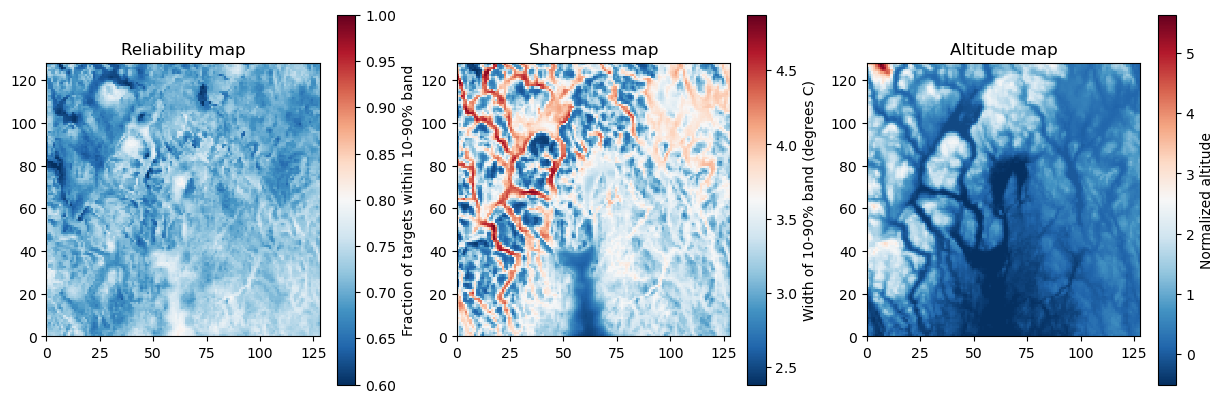

In [24]:
output = model.predict(datasets["test"]["predictors"].values, verbose=False)

plt.subplot(1,3,1)
plot_reliability_map(output, datasets["test"]["targets"].values[..., 0])
plt.subplot(1,3,2)
plot_sharpness_map(output)
plt.subplot(1,3,3)
plot_altitude(datasets["test"])
plt.gcf().set_figwidth(15, 5)

- _**Exercise**: Try training a model without using altitude and comment on the model's ability to create reliable forecasts for two whole domain_

## Part 4: Advanced models


### U-Net
Here we will test and compare advanced models. First we will test a U-Net model. We have implemented this complex model below:

In [25]:
def create_unet_model(input_shape, num_outputs, num_levels=3, num_features=16, pool_size=2, conv_size=3):
    """Create a U-Net model for 4D samples with dimensions leadtime, y, x, predictor
    
    Based on diagram found on https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/.
    
    Args:
        input_shape (list): Size of each dimension (must be 4D)
        num_outputs (int): How many output predictands are there?
        num_levels (int): How many levels in the U-Net?
        num_features (int): How many num_features in the top level?
        pool_size (int): What pooling ratio to use when down/upsampling?
        conv_size (int): What convolution size to use?
    Returns:
        keras.Model: Model object
    """
    inputs = keras.layers.Input(input_shape)
    levels = list()

    pool_size = [1, pool_size, pool_size] # was [1,...] originally
    conv_size = [3, conv_size, conv_size] # was [1,...] originally

    Conv = keras.layers.Conv3D

    # Downsampling
    # conv -> conv -> max_pool
    outputs = inputs
    for i in range(num_levels - 1):
        outputs = Conv(num_features, conv_size, activation="relu", padding="same")(
            outputs
        )
        outputs = Conv(num_features, conv_size, activation="relu", padding="same")(
            outputs
        )
        levels += [outputs]

        outputs = keras.layers.MaxPooling3D(pool_size=pool_size)(outputs)
        num_features *= 2

    # conv -> conv
    outputs = Conv(num_features, conv_size, activation="relu", padding="same")(
        outputs
    )
    # outputs = Conv(num_features, conv_size, activation="relu", padding="same")(
    #     outputs
    # )

    # upconv -> concat -> conv -> conv
    for i in range(num_levels - 2, -1, -1):
        num_features /= 2
        outputs = keras.layers.Conv3DTranspose(num_features, conv_size, strides=pool_size, padding="same")(outputs)

        outputs = keras.layers.concatenate((levels[i], outputs), axis=-1)
        outputs = Conv(num_features, conv_size, activation="relu", padding="same")(
            outputs
        )
        outputs = Conv(num_features, conv_size, activation="relu", padding="same")(
            outputs
        )

    # Dense layer at the end
    outputs = keras.layers.Dense(num_outputs, activation="linear")(
        outputs
    )

    return keras.Model(inputs, outputs)

Let's train a U-Net model. The model has a lot of parameters (over 100,000!) and takes a while to train...

In [26]:
datasets["train"]["predictor"]

<xarray.DataArray 'predictor' (predictor: 14)>
array(['air_temperature_0.1_2m', 'air_temperature_0.9_2m',
       'air_temperature_2m', 'bias_yesterday', 'cloud_area_fraction',
       'precipitation_amount', 'x_wind_10m', 'y_wind_10m', 'altitude',
       'analysis_std', 'bias_recent', 'land_area_fraction', 'model_altitude',
       'model_laf'], dtype=object)
Coordinates:
  * predictor  (predictor) object 'air_temperature_0.1_2m' ... 'model_laf'

In [27]:
optimizer = keras.optimizers.Adam(learning_rate=1.0e-4)
model = create_unet_model(input_shape, num_outputs, num_features=32)
model.compile(optimizer, loss=loss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10, 128, 12  0           []                               
                                8, 14)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 10, 128, 128  12128       ['input_3[0][0]']                
                                , 32)                                                             
                                                                                                  
 conv3d_1 (Conv3D)              (None, 10, 128, 128  27680       ['conv3d[0][0]']                 
                                , 32)                                                         

In [28]:
history = model.fit(datasets["train"]["predictors"].values, datasets["train"]["targets"].values, epochs=50, batch_size=16,
            validation_data=(datasets["val"]["predictors"].values, datasets["val"]["targets"].values))

Epoch 1/50
21/21 [==============================] - 21s 508ms/step - loss: 0.4308 - val_loss: 0.4096
Epoch 2/50
21/21 [==============================] - 4s 198ms/step - loss: 0.3563 - val_loss: 0.3871
Epoch 3/50
21/21 [==============================] - 4s 195ms/step - loss: 0.3400 - val_loss: 0.3730
Epoch 4/50
21/21 [==============================] - 4s 195ms/step - loss: 0.3295 - val_loss: 0.3678
Epoch 5/50
21/21 [==============================] - 4s 195ms/step - loss: 0.3204 - val_loss: 0.3656
Epoch 6/50
21/21 [==============================] - 4s 210ms/step - loss: 0.3135 - val_loss: 0.3595
Epoch 7/50
21/21 [==============================] - 4s 212ms/step - loss: 0.3088 - val_loss: 0.3541
Epoch 8/50
21/21 [==============================] - 4s 213ms/step - loss: 0.3050 - val_loss: 0.3499
Epoch 9/50
21/21 [==============================] - 4s 209ms/step - loss: 0.3021 - val_loss: 0.3505
Epoch 10/50
21/21 [==============================] - 4s 211ms/step - loss: 0.2994 - val_loss: 0.345

In [29]:
path = "unet.keras"
model.save("unet.keras")

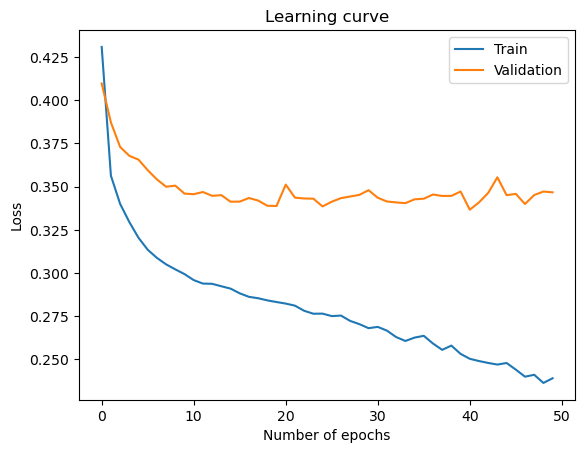

In [30]:
plt.plot(history.epoch, history.history["loss"], label="Train")
plt.plot(history.epoch, history.history["val_loss"], label="Validation")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Learning curve")
plt.legend()
plt.show()

In [ ]:
result = model.predict_on_batch(datasets["test"]["predictors"].values)
test_loss= quantile_score(datasets["test"]["targets"].values, result, quantiles).numpy()
print(f"Test loss: {test_loss}")

_**Exercise**: Investigate the importance of the predictors in the U-Net model_

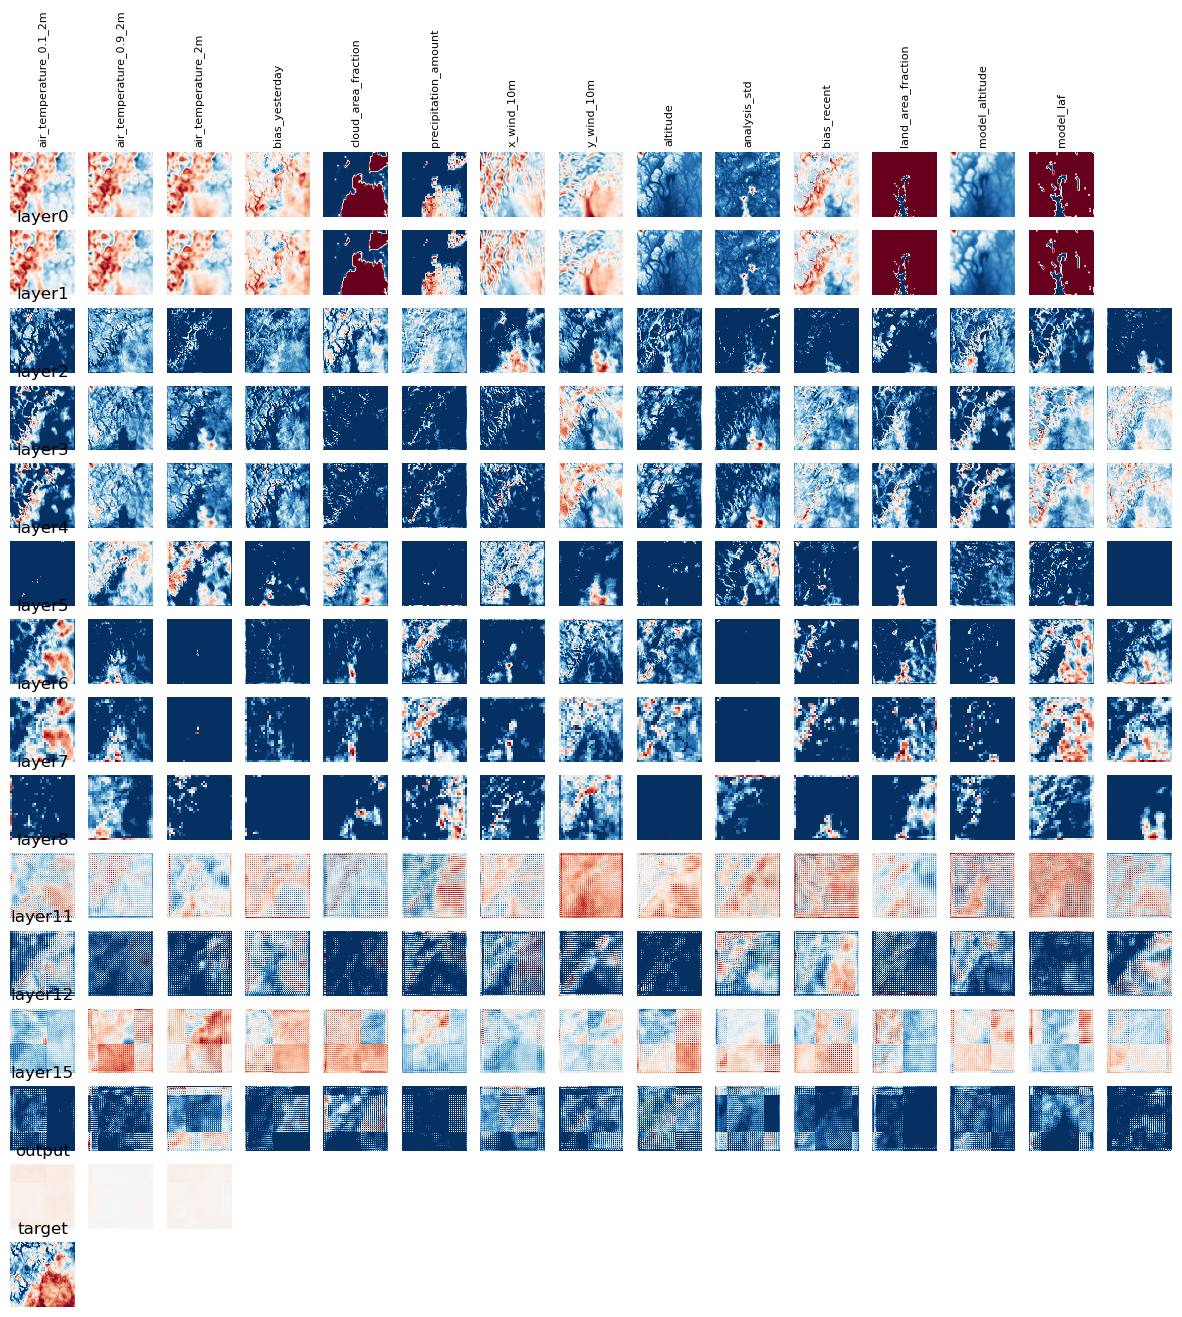

In [32]:
plot_model(model, datasets["test"], time_index=0, leadtime_index=8) # no es obligatorio mejorar todo, solo donde el malo (en este caso es peor mas adelante en el tiempo, hay mas spread)

### LSTM
Let's test an LSTM network. We will use reccurrence on the lead time dimension. `return_sequences` should be set to True to ensure that every leadtime is computed (otherwise, only the last leadtime is returned).

Por ejemplo util para profundidad de nieve, depende de lo q habia el dia anterior y lo q esta nevando hoy.

In [ ]:
num_filters = 3
conv_size = 1
def create_lstm_model(input_shape, num_outputs):
    return keras.Sequential([
        keras.layers.Input(input_shape),
        keras.layers.Dense(6, activation="relu"),
        keras.layers.ConvLSTM2D(num_filters, conv_size, padding="same", activation="relu", return_sequences=True),
        keras.layers.Dense(6, activation="relu"),
        keras.layers.Dense(num_outputs),
    ])

optimizer = keras.optimizers.Adam(learning_rate=1.0e-2)
lstm_model = create_lstm_model(input_shape, num_outputs)
lstm_model.compile(optimizer, loss=loss)
lstm_model.summary()
lstm_model.fit(datasets["train"]["predictors"].values, datasets["train"]["targets"].values, epochs=10, batch_size=1,
            validation_data=(datasets["val"]["predictors"].values, datasets["val"]["targets"].values))

_**Exercise**: Compare the performance of LSTM, U-Net, and CNN, using the evaluation framework of Part 4 in hands-on tutorial 1. Can you explain how the different models perform relativ to each other?_

## Part 5: Free time to investigate models

If there is time left over, use this time to investigate new models. In hands-on tutorial 3, we will submit large-scale jobs based on the large Tier 2 dataset using promising models that you choose yourself. Some suggestions:
- Develop new models by combining different types of layers that you've learned about in the tutorial.
- Fine-tune the hyper-parameters (e.g. learning-rate, epochs, batch size) of the models.
- Look at the tensorflow documentation and try layers and/or models that we have not covered here.
- Use the many diagnostic tools you have learned about in hands-on 1 and 2 to help you analyse the model performance.